# Adversary Attack en MobileNetV2 y ImageNet

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

CUDA: Configuracion necesaria para ejecucción en tarjetas graficas Nvidia GTX 1650, para permitir uso de memoria

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

cargando el modelo preentrando MobileNetV2 y los pesos y clases de  ImageNet.

In [3]:
pretrained_model = tf.keras.applications.MobileNetV2(include_top=True,
                                                     weights='imagenet')
pretrained_model.trainable = False
# ImageNet labels
decode_predictions = tf.keras.applications.mobilenet_v2.decode_predictions

In [4]:
# funcion de preparación de input para ser introducidos a MobileNetV2
def preprocess(image):
  image = tf.cast(image, tf.float32)
  image = image/255
  image = tf.image.resize(image, (224, 224))
  image = image[None, ...]
  return image

# Extración de labels desde el vector de probabilidades
def get_imagenet_label(probs):
  return decode_predictions(probs, top=1)[0][0]

## Importación imagen de prueba Original
Usaremos la imagen de tránsito. Las imágenes se carga de la siguiente forma

In [5]:
#IMAGEN 1
image_path1 = tf.keras.utils.get_file('signal_trafic01.jpg', 'https://images.thestar.com/OalNDDmehHAk0l9iD_ltxbAWsEo=/1086x725/smart/filters:cb(2700061000)/https://www.thestar.com/content/dam/thestar/news/canada/2014/09/05/slow_down_ontario_moves_to_cut_speed_limits_on_residential_streets/sign.jpg')
image_raw1 = tf.io.read_file(image_path1)
image1 = tf.image.decode_image(image_raw1)
image1 = preprocess(image1)
image_probs1 = pretrained_model.predict(image1)

#IMAGEN 2
image_path2 = tf.keras.utils.get_file('signal_trafic02.jpg', 'https://mklstatic01.azureedge.net/~/media/specialty/2018-web/defensive-driving/pedestrian-crossing.jpg?rev=2dbd6b65722b46a985942b13f9edc948')
image_raw2 = tf.io.read_file(image_path2)
image2 = tf.image.decode_image(image_raw2)
image2 = preprocess(image2)
image_probs2 = pretrained_model.predict(image2)


Visualizamos las imágenes

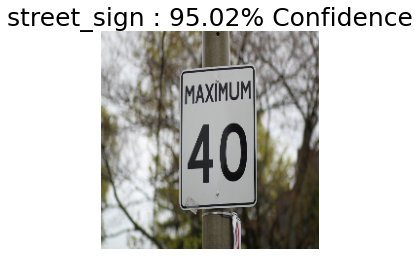

index: 919


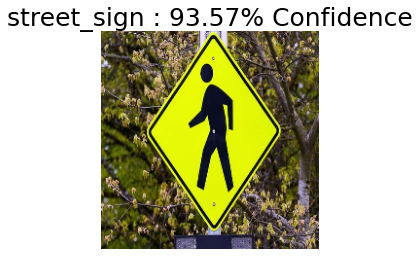

index: 919


In [6]:
#Figura 1
plt.figure()
plt.imshow(image1[0])
_, image_class1, class_confidence1 = get_imagenet_label(image_probs1)
plt.title('{} : {:.2f}% Confidence'.format(image_class1, class_confidence1*100),fontsize=25)
plt.axis(False)
plt.show()
print("index: " + str(np.argmax(image_probs1)))

#Figura 2
plt.imshow(image2[0])
_, image_class2, class_confidence2 = get_imagenet_label(image_probs2)
plt.title('{} : {:.2f}% Confidence'.format(image_class2, class_confidence2*100),fontsize=25)
plt.axis(False)
plt.show()
print("index: " + str(np.argmax(image_probs2)))

## Creando adversarial image

### fast gradient sign method
Calculo de gradiente decendiente de la imagen, respecto a su correcta clasificación utilizando la salida de la red (y su pérdida)

In [7]:
loss_object = tf.keras.losses.CategoricalCrossentropy()

def create_adversarial_pattern(input_image, input_label):
  with tf.GradientTape() as tape:
    tape.watch(input_image)
    prediction = pretrained_model(input_image)
    loss = loss_object(input_label, prediction)

  # Get the gradients of the loss w.r.t to the input image.
  gradient = tape.gradient(loss, input_image)
  # Get the sign of the gradients to create the perturbation
  signed_grad = tf.sign(gradient)
  return signed_grad

The resulting perturbations can also be visualised.

In [9]:
#Figura 1
image_index_class1 = np.argmax(image_probs1)
label1 = tf.one_hot(image_index_class1, image_probs1.shape[-1])

#Figura 2
image_index_class2 = np.argmax(image_probs2)
label2 = tf.one_hot(image_index_class2, image_probs2.shape[-1])


In [10]:
#Figura 1
label1 = tf.reshape(label1, (1, image_probs1.shape[-1]))

#Figura 2
label2 = tf.reshape(label2, (1, image_probs2.shape[-1]))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


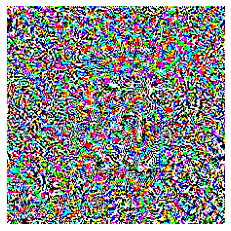

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


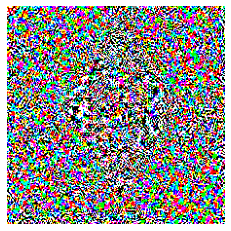

In [11]:
#Figura 1
perturbations1 = create_adversarial_pattern(image1, label1)
prediction_x1 = pretrained_model(image1)
loss_x1 = loss_object(label1, prediction_x1)
plt.imshow(perturbations1[0])
plt.axis(False)
plt.show()

#Figura 2
perturbations2 = create_adversarial_pattern(image2, label2)
prediction_x2 = pretrained_model(image2)
loss_x2 = loss_object(label2, prediction_x2)
plt.imshow(perturbations2[0])
plt.axis(False)
plt.show()

Let's try this out for different values of epsilon and observe the resultant image. You'll notice that as the value of epsilon is increased, it becomes easier to fool the network. However, this comes as a trade-off which results in the perturbations becoming more identifiable.

In [32]:
def display_images(image, description):
  _, label, confidence = get_imagenet_label(pretrained_model.predict(image))
  plt.figure()
  plt.imshow(image[0])
  plt.title('{} \n {} : {:.1f}% Prob.'.format(description,
                                                   label, confidence*100),fontsize=18)
  plt.axis(False)
  plt.show()

In [35]:
epsilons = [0, 0.01, 0.025, 0.05, 0.07, 0.1, 0.3, 0.5]


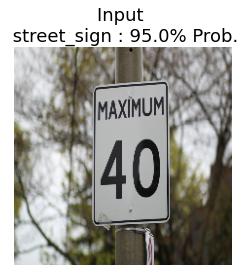

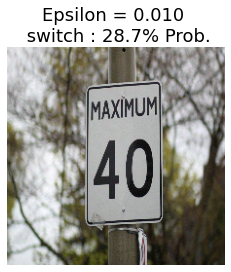

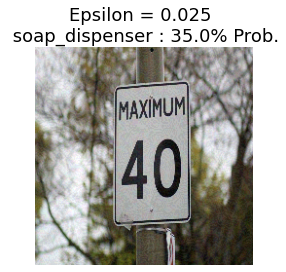

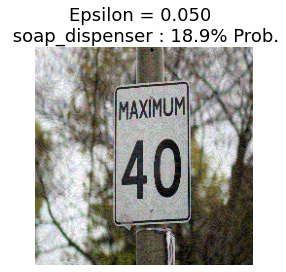

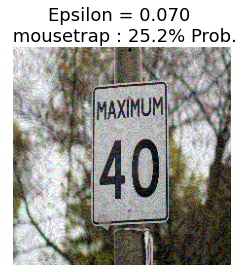

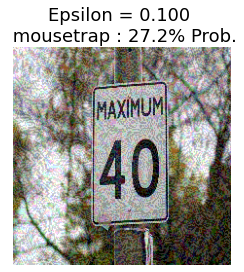

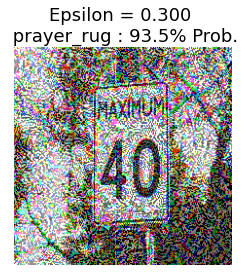

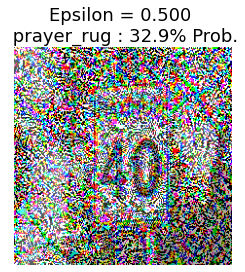

In [36]:
# IMAGEN 1 AL ATAQUE

descriptions = [('Epsilon = {:0.3f}'.format(eps) if eps else 'Input')
                for eps in epsilons]

for i, eps in enumerate(epsilons):
  adv_x = image1 + eps*perturbations1
  adv_x = tf.clip_by_value(adv_x, 0, 1)
  display_images(adv_x, descriptions[i])

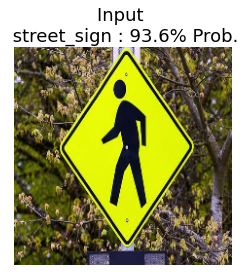

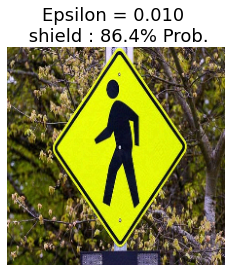

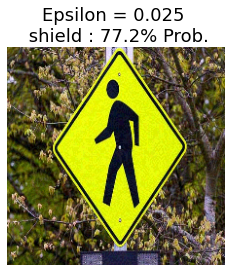

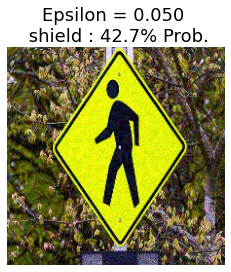

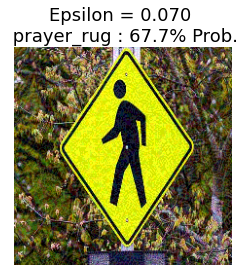

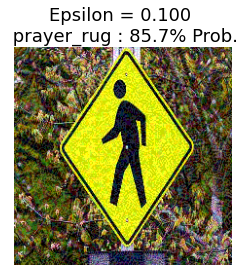

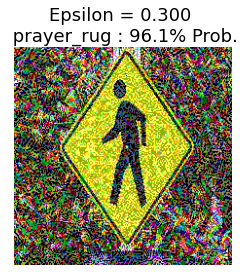

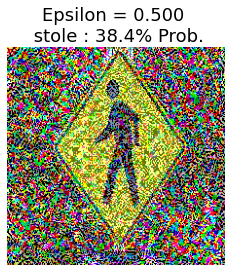

In [37]:
# IMAGEN 2 AL ATAQUE

descriptions = [('Epsilon = {:0.3f}'.format(eps) if eps else 'Input')
                for eps in epsilons]

for i, eps in enumerate(epsilons):
  adv_x = image2 + eps*perturbations2
  adv_x = tf.clip_by_value(adv_x, 0, 1)
  display_images(adv_x, descriptions[i])

Gracias!